<a href="https://colab.research.google.com/github/ludoveltz/test_github_fev25/blob/main/Daily_challenge_day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pokemon Dataset:
   #           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False  

Combats Dataset:
   First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3    

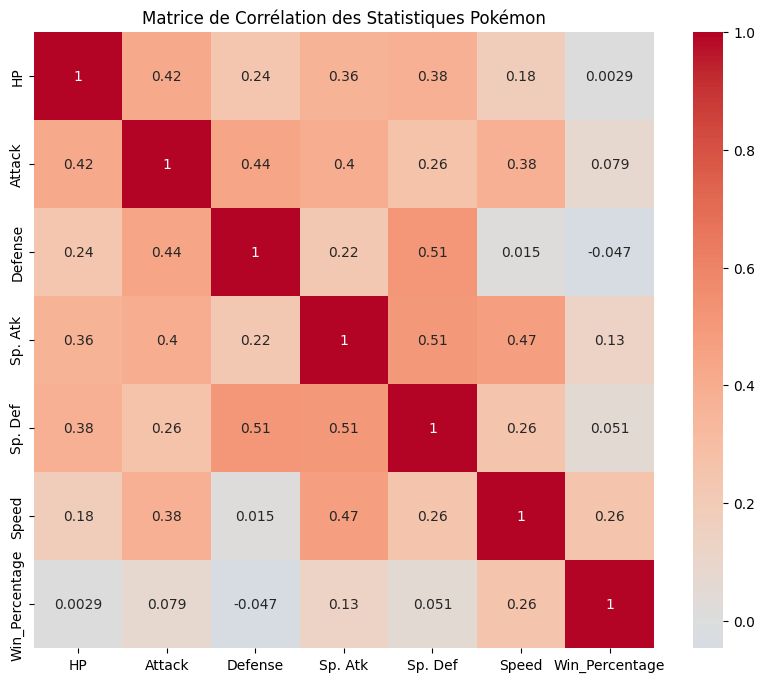

<Figure size 1500x1000 with 0 Axes>

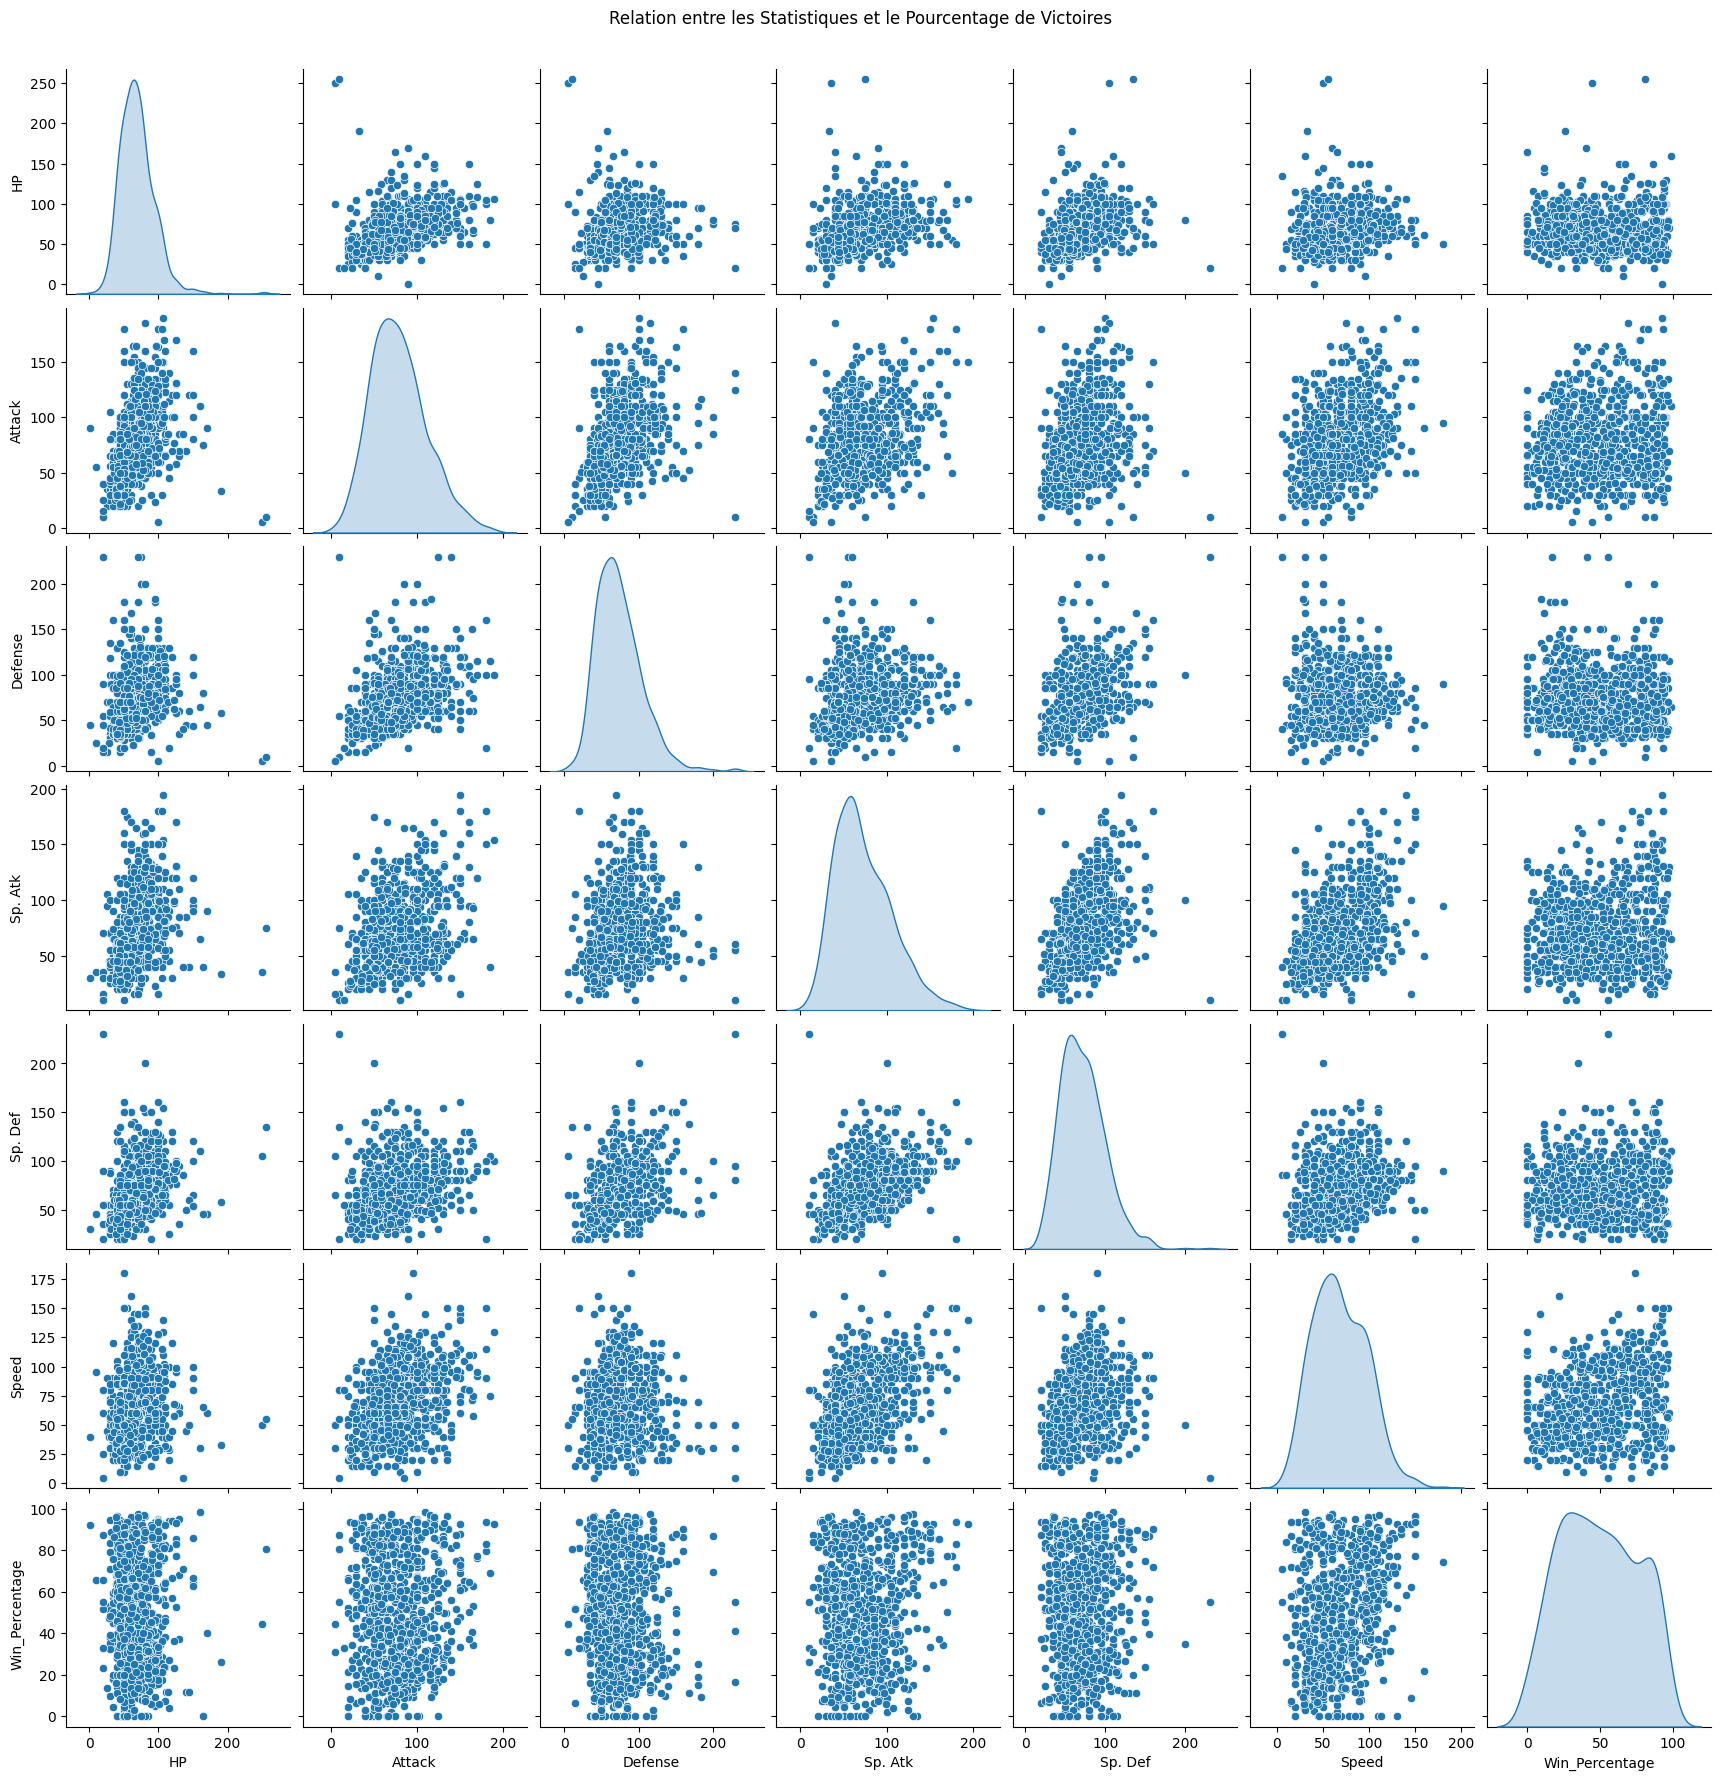


Top 10 des Pokémon par pourcentage de victoires:
                          Name    Type 1  Type 2  Win_Percentage   HP  Attack  \
155                    Snorlax    Normal    None       98.449612  160     110   
513                  Magnezone  Electric   Steel       97.478992   70      70   
704  Thundurus Incarnate Forme  Electric  Flying       96.800000   79     115   
20                      Pidgey    Normal  Flying       96.638655   40      45   
154            Mega Aerodactyl      Rock  Flying       96.453901   80     135   
477                  Mismagius     Ghost    None       96.124031   60      60   
727                   Bunnelby    Normal    None       96.062992   38      36   
717                   Genesect       Bug   Steel       95.934959   71     120   
165                        Mew   Psychic    None       95.200000  100     100   
350                    Wailmer     Water    None       95.000000  130      70   

     Defense  Sp. Atk  Sp. Def  Speed  
155       65      

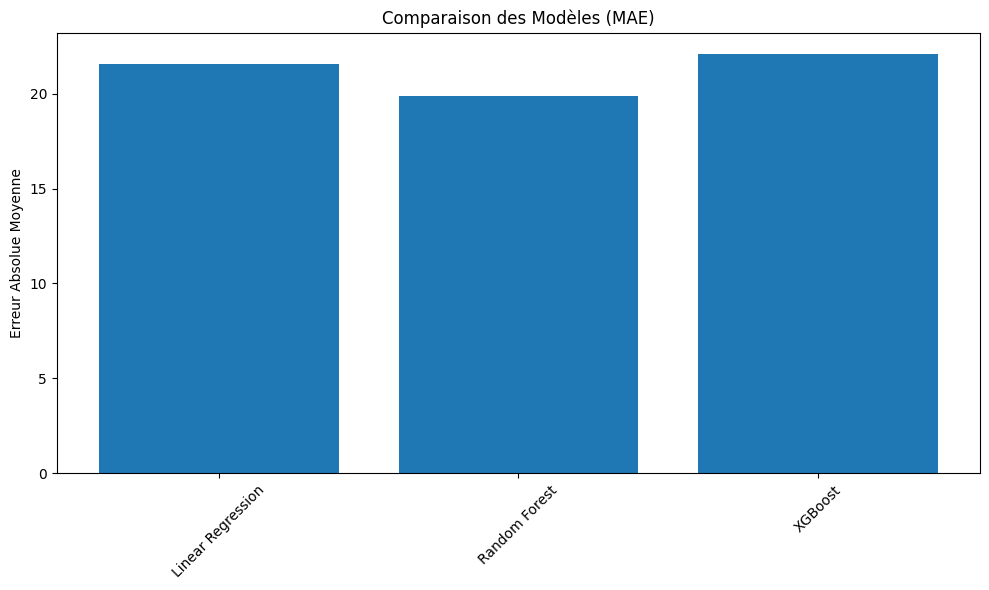

In [3]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Préparation des données
# Chargement des fichiers
pokemon_df = pd.read_csv('/content/drive/MyDrive/Pokemon Data Analysis Tutorial/pokemon.csv')
combats_df = pd.read_csv('/content/drive/MyDrive/Pokemon Data Analysis Tutorial/combats.csv')

# Afficher les premières lignes
print("Pokemon Dataset:")
print(pokemon_df.head())
print("\nCombats Dataset:")
print(combats_df.head())

# Correction des données manquantes
pokemon_df.loc[pokemon_df['#'] == 62, 'Name'] = 'Primeape'
pokemon_df['Type 2'] = pokemon_df['Type 2'].fillna('None')


# Calculer le pourcentage de victoires
def calculate_win_rates(pokemon_df, combats_df):
    # Créer un dictionnaire pour stocker les statistiques
    stats = {pokemon_id: {'wins': 0, 'total': 0} for pokemon_id in pokemon_df['#']}

    # Compter les victoires et les combats
    for _, row in combats_df.iterrows():
        first = row['First_pokemon']
        second = row['Second_pokemon']
        winner = row['Winner']

        # Incrémenter les compteurs
        stats[first]['total'] += 1
        stats[second]['total'] += 1
        stats[winner]['wins'] += 1

    # Calculer les pourcentages
    win_rates = {}
    for pokemon_id in stats:
        total = stats[pokemon_id]['total']
        if total > 0:
            win_rates[pokemon_id] = (stats[pokemon_id]['wins'] / total) * 100
        else:
            win_rates[pokemon_id] = 0.0  # Pour les Pokémon sans combat

    return pd.Series(win_rates)

# Ajouter les pourcentages de victoire et remplacer les NaN par 0
pokemon_df['Win_Percentage'] = calculate_win_rates(pokemon_df, combats_df)
pokemon_df['Win_Percentage'] = pokemon_df['Win_Percentage'].fillna(0)

# Vérification des NaN
print("Nombre de NaN dans Win_Percentage:", pokemon_df['Win_Percentage'].isna().sum())


# 2. Analyse exploratoire et visualisation
# Matrice de corrélation
numeric_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win_Percentage']
correlation_matrix = pokemon_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation des Statistiques Pokémon')
plt.show()

# PairPlot pour les statistiques vs pourcentage de victoires
plt.figure(figsize=(15, 10))
sns.pairplot(pokemon_df[numeric_cols], diag_kind='kde')
plt.suptitle('Relation entre les Statistiques et le Pourcentage de Victoires', y=1.02)
plt.show()

# Top 10 des Pokémon par pourcentage de victoires
top_10_pokemon = pokemon_df.nlargest(10, 'Win_Percentage')
print("\nTop 10 des Pokémon par pourcentage de victoires:")
print(top_10_pokemon[['Name', 'Type 1', 'Type 2', 'Win_Percentage'] + numeric_cols[:-1]])

# 3. Machine Learning
# Préparation des features
X = pokemon_df[numeric_cols[:-1]]  # Toutes les stats sauf Win_Percentage
y = pokemon_df['Win_Percentage']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement des modèles
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Évaluation des modèles
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae

# Affichage des résultats
print("\nPerformance des modèles (MAE):")
for name, mae in results.items():
    print(f"{name}: {mae:.2f}")

# Visualisation des performances
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Comparaison des Modèles (MAE)')
plt.ylabel('Erreur Absolue Moyenne')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()